# Distracted Driver Detection 

In [29]:
import numpy as np
import pandas as pd
import os

In [30]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

### Analyzing the data.

In [31]:
next(os.walk('/kaggle/input/state-farm-distracted-driver-detection'))

('/kaggle/input/state-farm-distracted-driver-detection',
 ['imgs'],
 ['sample_submission.csv', 'driver_imgs_list.csv'])

In [4]:
path='/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
df=pd.read_csv(path)
df.head()

,subject,classname,img
0,p012,c0,img_10206.jpg
1,p012,c0,img_27079.jpg
2,p012,c0,img_50749.jpg
3,p012,c0,img_97089.jpg
4,p012,c0,img_37741.jpg


In [5]:
df["subject"].value_counts() # image per subject which we have 

subject
p021    2474
p022    2466
p024    2452
p026    2392
p066    2068
p049    2022
p051    1840
p015    1750
p035    1696
p047    1670
p012    1646
p064    1640
p075    1628
p056    1588
p050    1580
p052    1480
p045    1448
p041    1210
p042    1182
p072     692
Name: count, dtype: int64

In [32]:
df.classname.value_counts() # the types of classes we have

classname
c0    3906
c4    3634
c6    3622
c3    3618
c5    3608
c2    3566
c1    3508
c9    3362
c7    3064
c8    3036
Name: count, dtype: int64

In [7]:
next(os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs'))

('/kaggle/input/state-farm-distracted-driver-detection/imgs',
 ['test', 'train'],
 [])

In [8]:
next(os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs/train'))

('/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
 ['c5', 'c7', 'c8', 'c2', 'c6', 'c4', 'c3', 'c1', 'c9', 'c0'],
 [])

### Getting path of each class

In [9]:
class_paths=[]
for dirname, _, filenames in os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs/train'):
    for a in _:
        cls_path=os.path.join(dirname, a)
        print(cls_path)
        class_paths.append(cls_path)

/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9
/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0


In [10]:
a,b,c = next(os.walk(class_paths[0]))
a,b,c[:11]

('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5',
 [],
 ['img_68208.jpg',
  'img_49189.jpg',
  'img_6690.jpg',
  'img_37376.jpg',
  'img_8327.jpg',
  'img_41485.jpg',
  'img_94685.jpg',
  'img_27794.jpg',
  'img_39084.jpg',
  'img_83292.jpg',
  'img_33938.jpg'])

### Seeing a sample image

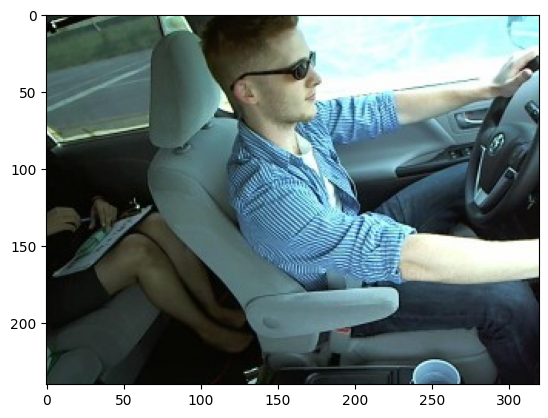

(240, 320, 3)

In [11]:
image1=cv2.cvtColor(cv2.imread('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_94685.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(image1)
plt.show()
image1.shape

### Preparing training data

In [12]:
train1=[]
labels=[]
i_ = 0
for class_path in class_paths:
    i_ = i_ + 1
    a_,b_,c_=next(os.walk(class_path))
    print(i_,"/",len(class_paths),a_)
#     print(a_,b_,c_)
    for c__ in c_:
        img_path=os.path.join(a_, c__)
#         print(a_[-1:], img_path)
        img=cv2.imread(img_path, cv2.IMREAD_COLOR)
        img=cv2.resize(img, (96,96))
        train1.append(img)
        labels.append(int(a_[-1:]))
#         break

1 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5
2 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7
3 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8
4 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2
5 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6
6 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4
7 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3
8 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1
9 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9
10 / 10 /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0


17462
96
96
3
[58 70 52]


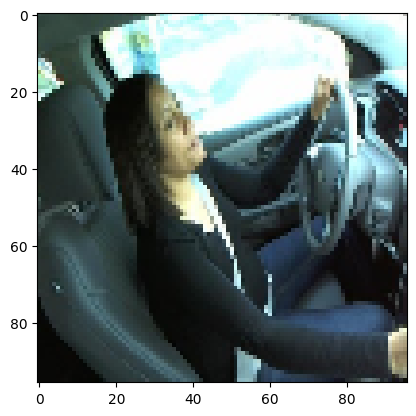

In [13]:
print(len(train1))
print(len(train1[0]))
print(len(train1[0][0]))
print(len(train1[0][0][0]))
print(train1[0][0][0])
plt.imshow(cv2.cvtColor(train1[1500], cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
print(np.array(labels).shape)
print(labels[:10])

(17462,)
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


### doing the one hot encoding of the output labels

In [15]:
y = tf.keras.utils.to_categorical(labels, 10)
print(type(y))
print(y[:10])
print(y[-10:])

<class 'numpy.ndarray'>
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [16]:
train=np.array(train1, dtype=np.float32).reshape(-1, 96, 96, 3)
print(np.max(train))
train=train/255
print(np.max(train))

255.0
1.0


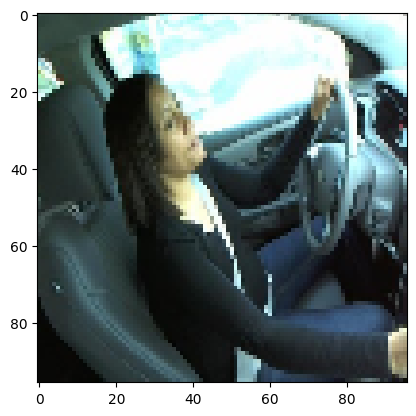

In [17]:
plt.imshow(cv2.cvtColor(train[1500], cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
type(train)

numpy.ndarray

In [19]:
set(labels) # all the unique types of labels we have i.e the number of classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### Splitting the data into train and test sets

In [20]:
X_train, X_test, y_train, y_test=train_test_split(train, y, test_size=0.2, random_state=0, stratify=labels)
print("Train label distribution:", np.sum(y_train, axis=0))
print("Test label distribution:", np.sum(y_test, axis=0))

Train label distribution: [1562. 1403. 1426. 1447. 1454. 1443. 1449. 1226. 1214. 1345.]
Test label distribution: [391. 351. 357. 362. 363. 361. 362. 306. 304. 336.]


### Making the model structure 

In [21]:
model=Sequential()
model.add(InputLayer(shape=(96,96,3)))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     9,216,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,848,006 (41.38 MB)

 Trainable params: 10,848,006 (41.38 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Setting up callbacks.

In [23]:
checkpointer=ModelCheckpoint(
    'saved_models/weights_best_vanilla.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
)

In [24]:
es=EarlyStopping(monitor='val_loss',mode='auto',verbose=1,patience=2,restore_best_weights=True)

In [25]:
X_train.shape

(13969, 96, 96, 3)

### Train the model

In [26]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=40,
    epochs=10,
    verbose='auto',
    callbacks=[checkpointer, es],
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
  2/315 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.0688 - loss: 3.4678   

I0000 00:00:1718860035.709926     149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718860035.729301     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2221 - loss: 2.1313

W0000 00:00:1718860053.096610     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718860054.278796     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.52178, saving model to saved_models/weights_best_vanilla.keras


W0000 00:00:1718860058.043716     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


315/315 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.2228 - loss: 2.1294 - val_accuracy: 0.8318 - val_loss: 0.5218
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8818 - loss: 0.3908
Epoch 2: val_loss improved from 0.52178 to 0.11619, saving model to saved_models/weights_best_vanilla.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8819 - loss: 0.3905 - val_accuracy: 0.9656 - val_loss: 0.1162
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9502 - loss: 0.1627
Epoch 3: val_loss improved from 0.11619 to 0.04993, saving model to saved_models/weights_best_vanilla.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9502 - loss: 0.1626 - val_accuracy: 0.9835 - val_loss: 0.0499
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9718 - loss: 0.0966
Epoch 4: val_loss improved from 0.04993 to 0.04138, saving model to saved_models/weights_best_vanilla.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9

In [27]:
model.evaluate(X_test,y_test)

 18/110 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9889 - loss: 0.0305 

W0000 00:00:1718860152.694781     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9900 - loss: 0.0359


W0000 00:00:1718860154.909221     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.03847716003656387, 0.9902662634849548]